# LAB 1 Kinematics: Simulation of a 4-DoF Serial Manipulator

Welcome to Assignment 1! In this tutorial, you will learn the following:
1. How to visualize a robot model using the Unified Robot Description Format (URDF).
2. How to compute and visualize the direct and inverse kinematics of a 4-DoF serial manipulator.

Here's an overview of what we will cover:

1. Describing the robot using the URDF convention: We will learn how to describe our robot using URDF, enabling ROS to visualize it using the RVIZ visualizer tool.
2. Computing kinematics: We will develop Python code to calculate direct and inverse kinematics for our robot manipulator. We will also design a simple trajectory using polynomials for the robot to follow.

By the end of this assignment, you will have gained a solid understanding of URDF, kinematics, and dynamics of robotic manipulators. Let's get started!

## 0. Preliminaries
Tools that we are going to be using in this assigment:
- [Python programming ](https://docs.python.org)
- [Robot Operating System (ROS)](https://www.ros.org/)
- [Pinocchio Library for Rigid Body Dynamics Algorithms](https://github.com/stack-of-tasks/pinocchio)
- [Locosim](https://github.com/mfocchi/locosim)

## 1 Robot URDF description file and visualization

### 1.1 Basic geometry description: Create your own URDF
A URDF (Unified Robot Description Format) is a file format commonly used in robotics to describe the structure and properties of a robot. It provides a standardized way to represent a robot's physical components such as links, joints, sensors, and visual elements.

In simpler terms, a URDF file is like a blueprint or a set of instructions that tells a computer how a robot is built. It defines the robot's geometry, the connections between its different parts, and additional information such as mass, inertia, and visual appearance.

By using a URDF, we can accurately model the robot's physical attributes, enabling simulations, visualization, and control of the robot in various software tools like ROS (Robot Operating System) and simulation environments like Gazebo.

In summary, a URDF file is a text-based document that describes the structure, properties, and appearance of a robot, allowing us to simulate and control it in a virtual environment.

By working on this exercise, you will gain a deeper understanding of how URDF files are used to represent robot models. You will also become familiar with key concepts such as link transformations, joint types, and visualizing the robot using simulation tools like RViz.

1. Start by reviewing the tutorial titled "Building a Visual Robot Model with URDF from Scratch" available [here](https://wiki.ros.org/urdf/Tutorials/Building%20a%20Visual%20Robot%20Model%20with%20URDF%20from%20Scratch).
2. Edit the URDF code of the "[robot.urdf](../../robot_urdf/robot.urdf)" file located in the "robot_urdf" directory. Alternatively, you can edit the code in the next cell and execute it. (Do not delete the first line `%%writefile ../../robot_urdf/robot.urdf`).
3. Run the next cell to visualize your robot in RViz.
4. Once you have reviewed the URDF model in RViz, stop the process by clicking the stop button ($\blacksquare$) located in the top bar.
5. Repeat the above processes for each URDF model in the "Building a Visual Robot Model with URDF from Scratch" tutorial.


In [ ]:
%%script false --no-raise-error
%%writefile ../../robot_urdf/robot.urdf
<?xml version="1.0"?>
<robot name="myfirst">
  <link name="base_link">
    <visual>
      <geometry>
        <cylinder length="0.6" radius="0.2"/>
      </geometry>
    </visual>
  </link>
</robot>

In [ ]:
%%script false --no-raise-error
%%bash
#no_execute
roslaunch ros_impedance_controller visualize.launch robot_name:='robot'

In [ ]:
%%script false --no-raise-error
!rostopic list

**<span style='color:red'>Remember to stop the process by clicking the stop button ($\blacksquare$) located in the top bar!</span>**

### Inspect ur4_2links URDF

1. Inspect the URDF code of [ur4_2links.urdf](../../robot_urdf/ur4_2links.urdf) file located in the "robot_urdf" directory.
2. Run the next cell to visualize the robot in RViz.
3. Once you have reviewed the URDF model in RViz, stop the process by clicking the stop button ($\blacksquare$) located in the top bar.

In [ ]:
%%script false --no-raise-error
%%bash
roslaunch ros_impedance_controller visualize.launch robot_name:='ur4_2links'

### Inspect ur4 URDF

1. Inspect the URDF code of [ur4.urdf](../../robot_urdf/ur4.urdf) file located in the "robot_urdf" directory.
2. Run the next cell to visualize the robot in RViz.
3. Once you have reviewed the URDF model in RViz, stop the process by clicking the stop button ($\blacksquare$) located in the top bar.

In [ ]:
%%script false --no-raise-error
%%bash
roslaunch ros_impedance_controller visualize.launch robot_name:='ur4'

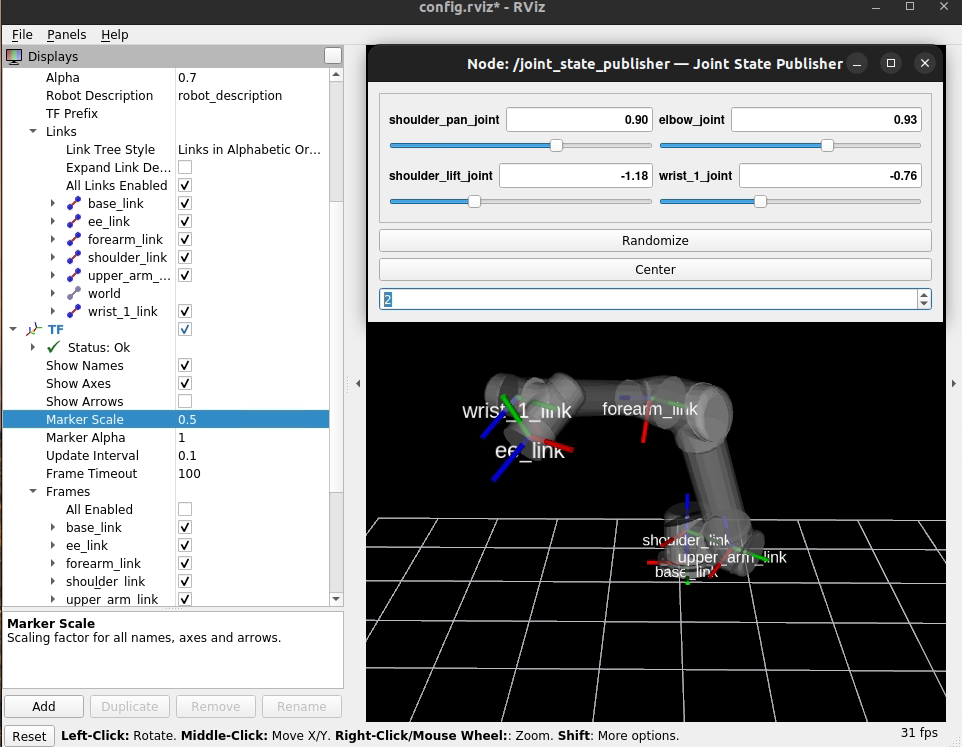

**<span style='color:red'>Remember to stop the process by clicking the stop button ($\blacksquare$) located in the top bar!</span>**

<a name='2'></a>
## 2 Robot kinematics
Once the model visualization is finished, we now proceed to derive and analyze the robot kinematics. In this part, we will manually compute the direct and inverse kinematics computations and verify their correctness using the built-in Pinocchio functions. We will perform this computations using the Python interface of Locosim.

### 2.0 Import necessary libraries and run ROS ans Rviz

In [1]:
# Import necessary libraries

import numpy as np
import math
import time as tm
import pinocchio as pin


from base_controllers.utils.math_tools import Math
from base_controllers.utils.ros_publish import RosPub
from base_controllers.utils.common_functions import *
from base_controllers.utils.kin_dyn_utils import *

# from base_controllers.components.inverse_kinematics.inv_kinematics_pinocchio import robotKinematics
# from IPython.display import display, Latex
from jupyter_tools import *

# Define the initial conditions
dt = 0.001                   # controller time step
SLOW_FACTOR = 5              # to slow down simulation
frame_name = 'ee_link'       # name of the frame to control (end-effector) in the URDF

# Initial Conditions
q0 =   np.array([math.pi, -math.pi/8,  -math.pi/6, 0.0]) # position
qd0 =  np.array([0.0, 0.0, 0.0, 0.0])                    # velocity
qdd0 = np.array([0.0, 0.0, 0.0, 0.0])                    # accelerations


q = q0
qd = qd0
qdd = qdd0

q_des = q0
qd_des = qd0
qdd_des = qdd0

math_utils = Math()

Initiate ROS and RViz

In [2]:
# instantiate graphic utils
ros_pub = RosPub("ur4")
robot = getRobotModel("ur4")

# get the ID corresponding to the frame we want to control
assert (robot.model.existFrame(frame_name))
frame_id = robot.model.getFrameId(frame_name)

Starting ros pub---------------------------------------------------------------
... logging to /home/legro/.ros/log/92063fc6-24a7-11ee-b7d2-50ebf67e77eb/roslaunch-superpc-43.log
started roslaunch server http://localhost:33443/

SUMMARY

PARAMETERS
 * /robot_description: <?xml version="1....
 * /rosdistro: noetic
 * /rosversion: 1.15.11

NODES
  /
    robot_state_publisher (robot_state_publisher/robot_state_publisher)
    rviz (rviz/rviz)

auto-starting new master
process[master]: started with pid [98]
ROS_MASTER_URI=http://localhost:11311
setting /run_id to 92063fc6-24a7-11ee-b7d2-50ebf67e77eb
process[rosout-1]: started with pid [139]
started core service [/rosout]
process[rviz-2]: started with pid [142]
process[robot_state_publisher-3]: started with pid [147]
[INFO] [1689601262.945045]: RVIZ started
Initialized ros pub---------------------------------------------------------------


Publish initial position

In [3]:
ros_pub.publish(robot, q0)

**Tips for Visualization:**

To enhance your understanding of the position and orientation of different frames in the quadruped robot, you can utilize the RViz visualization tool. Follow these steps to visualize the robot links and joints effectively:

1. Locate the "Displays" panel: In RViz, find the "Displays" panel, usually located on the left side of the screen. It contains various options for visualizing different aspects of the robot.
2. View the robot links and joints: With the RobotModel display configured, RViz will render the UR4 robot's links and joints in the visualization window. You can now observe the robot's structure and the relationships between its components.

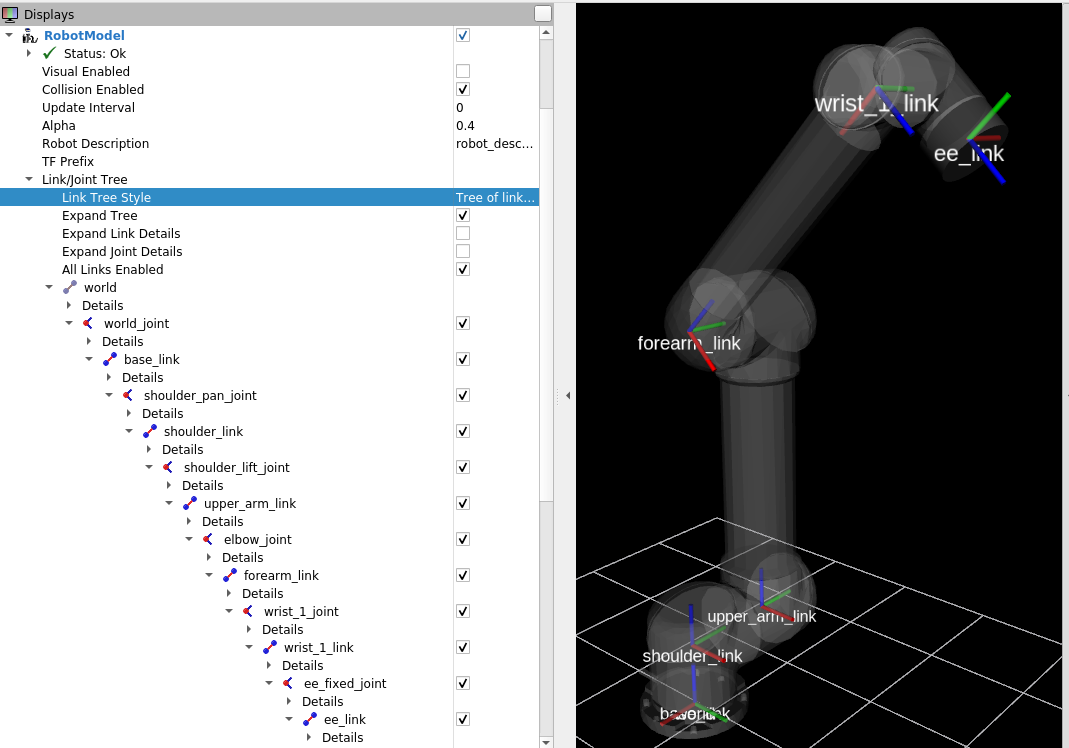
<!-- [](attachment:8655ff16-cf75-4746-8622-b2812f65d490.png) -->

To send positions to the UR4 robot, you can change the values of the joint positions as follows:

1. $q_1$ (shoulder_pan_joint): This joint controls the rotation of the robot's shoulder in the horizontal plane. Adjusting $q_1$ will change the angle of the shoulder rotation.
2. $q_2$ (shoulder_lift_joint): This joint controls the lifting or lowering motion of the robot's arm. Modifying $q_2$ will change the angle of the arm's vertical movement.
3. $q_3$ (elbow_joint): This joint controls the bending or straightening motion of the robot's elbow. Changing $q_3$ will alter the angle of the elbow joint.
4. $q_4$ (wrist_1_joint): This joint controls the rotation of the robot's wrist. Adjusting $q_4$ will change the angle of the wrist rotation.

By updating the values of these joint positions, you can send specific positions to the UR4 robot. Experiment with different values for each joint to observe how the robot responds and achieves different arm positions and orientations.

In [4]:
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

# Specify the positions of each joint in degrees
q1 = 90
q2 = -90
q3 = 45
q4 = 0
q = np.deg2rad(np.array([ q1, q2, q3, q4]))

# uncomment to reset to initial position
# q = q0 # initial position
assert len(q) == 4, "Check q, it returns the index of the largest value"

# Publish to rviz
ros_pub.publish(robot, q)

<a name='2.1'></a>
### 2.1 Direct kinematics


The first step is to obtain the homogeneous transformation matrix from the world frame to the end-effector ${}_{\mathbf{W}}{\mathbf{T}}_{e}$. To do so, you will need to obtain the homogeneous transformation matrices from one link to the other (i.e., the local transformations ${}_{\mathbf{W}}{\mathbf{T}}_{1}$, ${}_{\mathbf{1}}{\mathbf{T}}_{2}$, ${}_{\mathbf{2}}{\mathbf{T}}_{3}$, ${}_{\mathbf{3}}{\mathbf{T}}_{4}$ and ${}_{\mathbf{4}}{\mathbf{T}}_{e}$) and perform the composition of matrices. Modify the function inside to perform this computation.  
_original code: [L1_1_kinematics.py](L1_1_kinematics.py), [kin_dyn_utils.py](../base_controllers/utils/kin_dyn_utils.py)._

In [5]:
def directKinematics(q):
    
    # define link lengths from urdf
    link_length,_,_,_ = setRobotParameters()
    l1 = link_length[0]  # shoulder Z axis
    l2 = link_length[1]  # upper-arm Y axis
    l3 = link_length[2]  # forearm Z axis
    l4 = link_length[3]  # forearm Y axis
    l5 = link_length[4]  # wrist_1_link Z axis
    l6 = link_length[5]  # ee Y axis
    l7 = link_length[6]  # ee Z axis

    q1 = q[0] # shoulder_pan joint position
    q2 = q[1] # shoulder_lift joint position
    q3 = q[2] # elbow joint position
    q4 = q[3] # wrist_1_joint joint position

    # LOCAL homogeneous transformation matrices (base link is 0)
    
    # YOUR CODE STARTS HERE
    # -----------------------------------------------------------
    # shoulder link (1)
    # rigid transform (translation along Z axis)
    T_01r = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, l1],
                       [0, 0, 0, 1]])
    # joint transform (rotation about Z axis)
    T_1r1 = np.array([[math.cos(q1), -math.sin(q1), 0, 0],
                      [math.sin(q1), math.cos(q1),  0, 0],
                      [0,               0,              1, 0],
                      [0,               0,              0, 1]])
    # local hom. transform from link frame 0 to link frame 1
    T_01 = T_01r.dot(T_1r1)

    # upper-arm link (2)
    # rigid transform (90deg rotation about Y axis, translation l2 along Y axis)
    T_12r = np.array([[ 0, 0, 1,  0],
                       [ 0, 1, 0, l2],
                       [-1, 0, 0,  0],
                       [ 0, 0, 0,  1]])
    # joint transform (rotation about Y axis)
    T_2r2 = np.array([[ math.cos(q2), 0, math.sin(q2),        0],
                     [              0, 1,            0,        0],
                     [-math.sin(q2), 0, math.cos(q2), 0],
                     [              0, 0,              0, 1]])
    # local hom. transform from link frame 1 to link frame 2
    T_12 = T_12r.dot(T_2r2)


    # forearm link (3)
    # rigid transform (translation l3 along Zaxis, -l4 along Y axis)
    T_23r = np.array([[1, 0, 0, 0],
                       [0, 1, 0, -l4],
                       [0, 0, 1, l3],
                       [0, 0, 0, 1]])

    # joint transform (rotation about Y axis)
    T_3r3 = np.array([[ math.cos(q3) ,  0, math.sin(q3),   0],
                       [            0,  1,            0,   0],
                       [-math.sin(q3),  0, math.cos(q3),   0],
                       [            0,  0,            0,   1]])
    #local hom. transform from link frame 2 to link frame 3
    T_23 = T_23r.dot(T_3r3)

    # wrist_1 link (4)
    # rigid transform (90 deg about Y axis, l5 translation along Z axis)
    T_34r = np.array([[ 0, 0, 1,  0],
                      [ 0, 1, 0,  0],
                      [ -1, 0, 0,  l5],
                      [ 0, 0, 0,  1]])
    # joint transform  (rotation about Y axis)
    T_4r4 = np.array([[ math.cos(q4), 0, math.sin(q4), 0],
                     [              0, 1,              0, 0],
                     [-math.sin(q4), 0, math.cos(q4), 0],
                     [              0, 0,              0, 1]])
    #local hom. transform from link frame 3 to link frame 4
    T_34 = T_34r.dot(T_4r4)

    # end-effector
    # only rigid transform (rotation X => Y , Y => -X, translation l6 along Y axis, l7 along Z axis)
    T_4e = np.array([[0,  -1, 0,  0],
                     [1,   0, 0, l6],
                     [0,   0, 1, l7],
                     [0,   0, 0,  1]])

    # GLOBAL homogeneous transformation matrices
    T_02 = T_01.dot(T_12)
    T_03 = T_02.dot(T_23)
    T_04 = T_03.dot(T_34)
    T_0e = T_04.dot(T_4e)
    # -----------------------------------------------------------
    # YOUR CODE ENDS HERE
    
    return T_01, T_02, T_03, T_04, T_0e 

In [6]:
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

q = q0 # initial position

# define the angle of the joint
# q = np.array([3., 1., 1.,  1.])

assert len(q) == 4, "Check your argmax implementation returns the index of the largest value"

T_01, T_02, T_03, T_04, T_0e = directKinematics(q)

display_matrix("T_{01}", T_01)
display_matrix("T_{02}", T_02)
display_matrix("T_{03}", T_03)
display_matrix("T_{04}", T_04)
display_matrix("T_{0e}", T_0e)

# Publish to rviz
ros_pub.publish(robot, q)

$T_{01} = \begin{bmatrix}-1.00 & -0.00 & 0.00 & 0.00 \\
0.00 & -1.00 & 0.00 & 0.00 \\
0.00 & 0.00 & 1.00 & 0.09 \\
0.00 & 0.00 & 0.00 & 1.00\end{bmatrix}$

$T_{02} = \begin{bmatrix}-0.38 & -0.00 & -0.92 & -0.00 \\
0.00 & -1.00 & 0.00 & -0.14 \\
-0.92 & 0.00 & 0.38 & 0.09 \\
0.00 & 0.00 & 0.00 & 1.00\end{bmatrix}$

$T_{03} = \begin{bmatrix}-0.79 & -0.00 & -0.61 & -0.39 \\
0.00 & -1.00 & 0.00 & -0.02 \\
-0.61 & 0.00 & 0.79 & 0.25 \\
0.00 & 0.00 & 0.00 & 1.00\end{bmatrix}$

$T_{04} = \begin{bmatrix}0.61 & -0.00 & -0.79 & -0.63 \\
-0.00 & -1.00 & 0.00 & -0.02 \\
-0.79 & 0.00 & -0.61 & 0.56 \\
0.00 & 0.00 & 0.00 & 1.00\end{bmatrix}$

$T_{0e} = \begin{bmatrix}-0.00 & -0.61 & -0.79 & -0.69 \\
-1.00 & 0.00 & 0.00 & -0.11 \\
0.00 & 0.79 & -0.61 & 0.52 \\
0.00 & 0.00 & 0.00 & 1.00\end{bmatrix}$

To verify the correctness of your direct kinematics function, compare the outputs with the ones from the built-in functions from Pinocchio for the position vector (`robot.framePlacement(q, frame_ee).translation`) and the rotation matrix (`robot.framePlacement(q, frame_ee).rotation`).

In [7]:
# Tested Cell
# -----------
# compute the transformation matrix with with Pinocchio library
assert np.shape(T_01) == (4, 4), display_error("T_01")
robot.computeAllTerms(q, qd)
x = robot.framePlacement(q, frame_id).translation
o = robot.framePlacement(q, frame_id).rotation

# compare with your function `directKinematics(q)`
position_diff = x - T_0e[:3, 3]
rotation_diff = o - T_0e[:3, :3]

assert np.all(abs(position_diff)<1e-6), display_error("translation")
assert np.all(abs(rotation_diff)<1e-6), display_error("rotation")
display_congratulations()

**<span style='color:green'>Congratulations on your successful implementation!!</span>**

### 2.2 Geometric Jacobian




Now that you have implemented a function to compute the direct kinematics, proceed to to compute the end-effector Jacobian of the manipulator by modifying the function in `computeEndEffectorJacobian(q)`. 

Recall that the expression to compute the geometric Jacobian is: 
$$
\mathbf{J} = \begin{bmatrix}
        \mathbf{J}_{P1} & \dots & \mathbf{J}_{Pi} \\
        \mathbf{J}_{O1} & \dots & \mathbf{J}_{Oi}
    \end{bmatrix}
$$


where 
$$
\begin{bmatrix}
        \mathbf{J}_{Pi}\\
        \mathbf{J}_{Oi}
    \end{bmatrix} = 
    \begin{cases}
        \begin{bmatrix}
            \mathbf{z}_i \\
            \mathbf{0}
        \end{bmatrix} \text{   if $i$ is prismatic} \\
        \\
        \begin{bmatrix}
            \mathbf{z}_i \times ({}_{\mathbf{W}}{\mathbf{p}}_{e} - {}_{\mathbf{W}}{\mathbf{p}}_{i}) \\
            \mathbf{z}_i
        \end{bmatrix}\text{   if $i$ is revolute}
    \end{cases}
$$


In our case all of the joints are revolute. Recall as well that in this expression vector $\mathbf{z}_i$ represents the moving axis of joint $i$ that drives link $i$, expressed in the world frame.

In [9]:
def computeEndEffectorJacobian(q):
    # compute direct kinematics 
    T_01, T_02, T_03, T_04, T_0e = directKinematics(q)

    # YOUR CODE STARTS HERE
    # -----------------------------------------------------------
    # link position vectors
    p_01 = T_01[:3,3]
    p_02 = T_02[:3,3]
    p_03 = T_03[:3,3]
    p_04 = T_04[:3,3]
    p_0e = T_0e[:3,3]

    # z vectors for rotations
    z1 = T_01[:3,2] # Z axis
    z2 = T_02[:3,1] # Y axis
    z3 = T_03[:3,1] # Y axis
    z4 = T_04[:3,1] # Y axis

    # vectors from link i to end-effector
    p_0_1e = p_0e - p_01
    p_0_2e = p_0e - p_02
    p_0_3e = p_0e - p_03
    p_0_4e = p_0e - p_04

    # linear part of Jacobian matrix
    J_p = np.hstack((np.cross(z1,p_0_1e).reshape(3,1) , 
                     np.cross(z2,p_0_2e).reshape(3,1) , 
                     np.cross(z3,p_0_3e).reshape(3,1) , 
                     np.cross(z4,p_0_4e).reshape(3,1) ))
     # angular part of Jacobian matrix
    J_o = np.hstack((z1.reshape(3,1), 
                     z2.reshape(3,1), 
                     z3.reshape(3,1), 
                     z4.reshape(3,1)))

    # Jacobian matrix and joint axes both expressed in the world frame) 
    J = np.vstack(( J_p, J_o))
    # -----------------------------------------------------------
    # YOUR CODE ENDS HERE
    
    return J, z1, z2, z3, z4, T_0e

In [10]:
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

q = q0 # initial position
# q = np.array([math.pi, -math.pi/8,  -math.pi/6, 0.0])

assert len(q) == 4, "Check your argmax implementation returns the index of the largest value"

J, z1, z2, z3, z4, T_0e = computeEndEffectorJacobian(q)

# display_matrix("z_1", z1)
# display_matrix("z_2", z2)
# display_matrix("z_3", z3)
# display_matrix("z_4", z4)
display_matrix("_0 T_e", T_0e)
display_matrix("J", J)

# Publish to rviz
ros_pub.publish(robot, q)

$_0 T_e = \begin{bmatrix}-0.00 & -0.61 & -0.79 & -0.69 \\
-1.00 & 0.00 & 0.00 & -0.11 \\
0.00 & 0.79 & -0.61 & 0.52 \\
0.00 & 0.00 & 0.00 & 1.00\end{bmatrix}$

$J = \begin{bmatrix}0.11 & -0.43 & -0.27 & 0.04 \\
-0.69 & 0.00 & 0.00 & -0.00 \\
0.00 & -0.69 & -0.29 & -0.05 \\
0.00 & -0.00 & -0.00 & -0.00 \\
0.00 & -1.00 & -1.00 & -1.00 \\
1.00 & 0.00 & 0.00 & 0.00\end{bmatrix}$

To verify the correctness of your Geometric Jacobian, compare your results with the built-in function of Pinocchio: 
```python
robot.frameJacobian(q, frame_ee, False, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
```
for different values of $q$.

In [11]:
# Tested Cell
# -----------
# compute the transformation matrix with with Pinocchio library
assert np.shape(J) == (6, 4), display_error("J it returns the index of the largest valu")
Jee = robot.frameJacobian(q, frame_id, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
# compare with your function `directKinematics(q)`
jacobian_diff = J - Jee

assert np.all(abs(jacobian_diff)<1e-6), display_error("`computeEndEffectorJacobian(q)`") 
display_congratulations()

**<span style='color:green'>Congratulations on your successful implementation!!</span>**

### 2.3 Analytical Jacobian


In the case we decide to parametrize our task variables representing the orientation with Euler Angles, we can obtain the Analytic Jacobian directly from the Geometric Jacobian via a simple transformation. Proceed to compute the analytical Jacobian $\mathbf{J}_a$ according to: 
$$
\mathbf{J}_a = \mathbf{T}_{RPY} \mathbf{J}
$$
 where $\mathbf{J}$ is the geometric Jacobian and $\mathbf{T}_a$ is the transformation matrix given by 
$$
\mathbf{T}_a = \begin{bmatrix}
        \mathbf{I} & \mathbf{0} \\
        \mathbf{0} & \mathbf{T}_{RPY}^{-1}
    \end{bmatrix}
$$


where $\mathbf{T}_{RPY}^{-1}$ is the transformation matrix from angular velocity $\boldsymbol{\omega}$ to Euler angle rate $\dot{\mathbf{\Phi}}$, i.e., 
$$
\boldsymbol{\omega} = \mathbf{T}_{RPY} \dot{\mathbf{\Phi}}
$$
and implement it in the function `geometric2analyticJacobian`.

In [13]:
#### exercise 2.3: Analytical Jacobian
def geometric2analyticJacobian(J, T_0e):
    # compute direct kinematics 
    # T_01, T_02, T_03, T_04, T_0e = directKinematics(q)
    
    # cinoute RPY 
    R_0e = T_0e[:3,:3]
    math_utils = Math()
    rpy_ee = math_utils.rot2eul(R_0e)
    roll = rpy_ee[0]
    pitch = rpy_ee[1]
    yaw = rpy_ee[2]
    
    # YOUR CODE STARTS HERE
    # -----------------------------------------------------------
    # compute the mapping between euler rates and angular velocity
    T_w = np.array([[math.cos(yaw)*math.cos(pitch),  -math.sin(yaw), 0],
                    [math.sin(yaw)*math.cos(pitch),   math.cos(yaw), 0],
                    [             -math.sin(pitch),               0, 1]])

    T_a = np.array([np.vstack((np.hstack((np.identity(3), np.zeros((3,3)))),
                               np.hstack((np.zeros((3,3)),np.linalg.inv(T_w)))))])


    J_a = np.dot(T_a, J)
    # -----------------------------------------------------------
    # YOUR CODE ENDS HERE
    return J_a[0]

In [14]:
Ja = geometric2analyticJacobian(J, T_0e)
display_matrix("Ja", Ja)

$Ja = \begin{bmatrix}0.11 & -0.43 & -0.27 & 0.04 \\
-0.69 & 0.00 & 0.00 & -0.00 \\
0.00 & -0.69 & -0.29 & -0.05 \\
0.00 & 1.00 & 1.00 & 1.00 \\
0.00 & 0.00 & 0.00 & 0.00 \\
1.00 & 0.00 & 0.00 & 0.00\end{bmatrix}$

---
Let's have a look to the structure of the Analytical Jacobian and compare with the Geometrical one both computed at the $q_0$ configuration. There is a rows of zeros in the angular (the lienar part is the same) part in two different directions, why is that?
$$
J = \begin{bmatrix}0.110 & -0.432 & -0.270 & 0.041 \\
-0.685 & 0.000 & 0.000 & -0.000 \\
0.000 & -0.685 & -0.293 & -0.054 \\
0.000 & -0.000 & -0.000 & -0.000 \\
0.000 & -1.000 & -1.000 & -1.000 \\
1.000 & 0.000 & 0.000 & 0.000\end{bmatrix}
\qquad
Ja = \begin{bmatrix}0.110 & -0.432 & -0.270 & 0.041 \\
-0.685 & 0.000 & 0.000 & -0.000 \\
0.000 & -0.685 & -0.293 & -0.054 \\
0.000 & 1.000 & 1.000 & 1.000 \\
0.000 & 0.000 & 0.000 & 0.000 \\
1.000 & 0.000 & 0.000 & 0.000\end{bmatrix}
$$

This fact gives us the chance to deeply understand the difference between the two Jacobian. Let's have a look to the orientation of the end-effector frame in the $q_0 = ( \pi, -\pi/8, -\pi/6, 0 )$ configuration.

In the case of the Geometric Jacobian the row of zeros is the 3rd one, while in the Analitic is the 4th. This is reasonable because in the Geometric we have $\omega$ as output which is defined in in the world frame (Euclidean). 

Considering the kinematic structure of the robot there is no motion of the joints that can create a change of of orientation for the end effector about the X axis (red arrow). 

In the case of the Geometric Jacobian is the 4th row instead. This is meaningful if we consider that the Geometric Jacobian maps into Euler Rates which are subsequent rotations of the end-effector axes. In this case it is intuitive to see that there is no motion of the joints that can create a local rotation about the pitch (Y axis green) of the end-effector. 

Are all this findings are specific of the $q_0$ configuration or there is something more structural? 

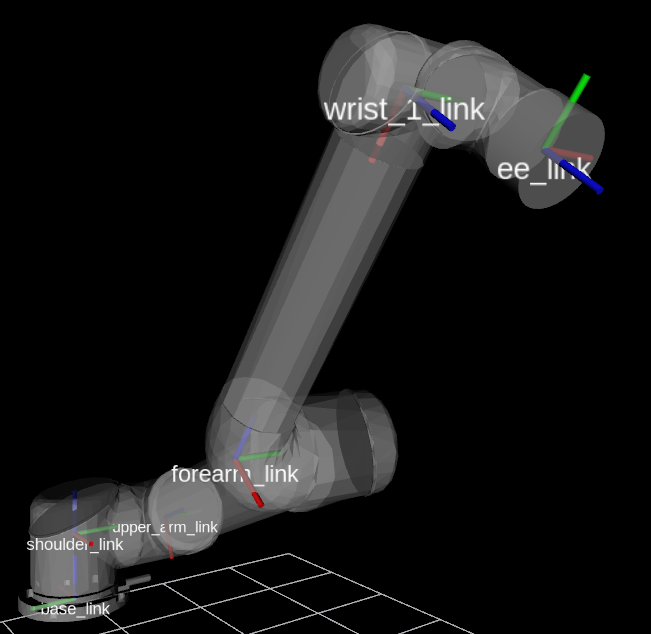

**Try it Yourself:**

In [15]:
# q0 =   np.array([math.pi, -math.pi/8,  -math.pi/6, 0.0])
q = q0
ros_pub.publish(robot, q)
J, z1, z2, z3, z4, T_0e = computeEndEffectorJacobian(q)
Ja = geometric2analyticJacobian(J, T_0e)
# display_matrix("J", J)
# display_matrix("Ja", Ja)

Let's recompute the Jacobians after subtracting $90^\circ$ ($q = [\pi/2, -\pi/8, -\pi/6, 0]$) to the `shoulder_pan_joint`? 

$$
J = \begin{bmatrix}-0.685 & 0.000 & 0.000 & -0.000 \\
-0.110 & 0.432 & 0.270 & -0.041 \\
0.000 & -0.685 & -0.293 & -0.054 \\
0.000 & -1.000 & -1.000 & -1.000 \\
0.000 & 0.000 & 0.000 & 0.000 \\
1.000 & 0.000 & 0.000 & 0.000\end{bmatrix}
\qquad
Ja = \begin{bmatrix}-0.685 & 0.000 & 0.000 & -0.000 \\
-0.110 & 0.432 & 0.270 & -0.041 \\
0.000 & -0.685 & -0.293 & -0.054 \\
0.000 & 1.000 & 1.000 & 1.000 \\
0.000 & 0.000 & 0.000 & 0.000 \\
1.000 & 0.000 & 0.000 & 0.000\end{bmatrix}
$$

In this case the rows of zeros in both Jacobians is the 4-th one, which related to the fact that, in this configuration, no joint can change orientation of the end-effector frame w.r.t to the Y axis of the base link (in the case of the Geometric Jacobian). The linear part is also the same but different from the previous case. 

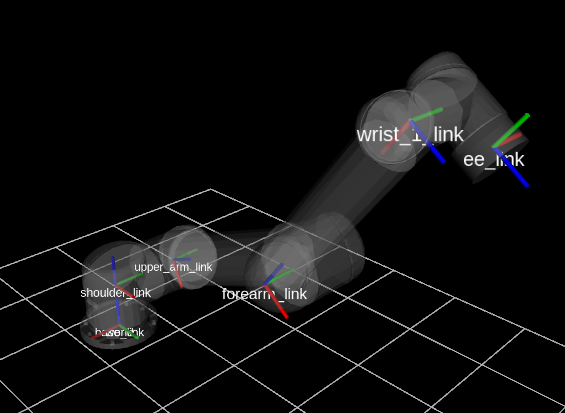

**Try it Yourself:**

In [16]:
q0 =  np.array([math.pi, -math.pi/8,  -math.pi/6, 0.0])
q = q0 +  np.array([-np.pi/2, 0, 0, 0])
ros_pub.publish(robot, q)
J, z1, z2, z3, z4, T_0e = computeEndEffectorJacobian(q)
Ja = geometric2analyticJacobian(J, T_0e)
# display_matrix("J", J)
# display_matrix("Ja", Ja, print_py=1)

If we move only $45^\circ$ the instead we get these results:
$$
J = \begin{bmatrix}-0.407 & -0.306 & -0.191 & 0.029 \\
-0.563 & 0.306 & 0.191 & -0.029 \\
0.000 & -0.685 & -0.293 & -0.054 \\
0.000 & -0.707 & -0.707 & -0.707 \\
0.000 & -0.707 & -0.707 & -0.707 \\
1.000 & 0.000 & 0.000 & 0.000\end{bmatrix}
\qquad
Ja = \begin{bmatrix}-0.407 & -0.306 & -0.191 & 0.029 \\
-0.563 & 0.306 & 0.191 & -0.029 \\
0.000 & -0.685 & -0.293 & -0.054 \\
0.000 & 1.000 & 1.000 & 1.000 \\
0.000 & -0.000 & -0.000 & -0.000 \\
1.000 & 0.000 & 0.000 & 0.000\end{bmatrix}
$$
Again, the linear part changed w.r.t the previous case, but while the Analytic Jacobian still maintain the 4th row of zeros, the Geometric Jacobian no longer has it. This highlights the fact that, being the Euler Angles subsequent rotations, and the Euler Rates the infinitesimal changes of these angles, they are expresssed about the end-effector axes, hence they have a \"local\" meaning. This is independent by the overall orientation of the arm w.r.t to the base link (dictated by the `shoulder_pan_joint`). Instead, the Geometric Jacobian (orientation part) always spits out the vector $\omega$ of angular velocity, which represents the rate of change of the orientation of the end-effector axes with respect to the base frame axes, hence it is affected by the `shoulder_pan_joint`.

**Try it Yourself:**

In [17]:
q = [np.pi-np.pi/4, -np.pi/8 , -np.pi/6,  0.]
ros_pub.publish(robot, q)
J, z1, z2, z3, z4, T_0e = computeEndEffectorJacobian(q)
Ja = geometric2analyticJacobian(J, T_0e)
# display_matrix("J", J, print_py=1)
# display_matrix("Ja", Ja, print_py=1)

### 2.4 Numerical inverse kinematics

Now you have all the necessary ingredients to compute the manipulator's inverse kinematics. Since we have 4-DoF, the analytical solution of the inverse kinematics problems is not straightforward, so we suggest to take the iterative approach given by the algorithm described in:

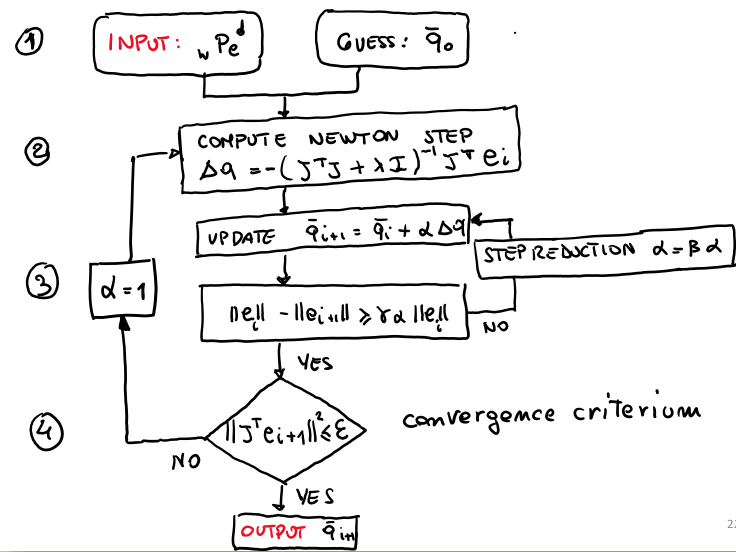


To start simple, consider your task space variables to be the Cartesian space position (i.e., $x,y,z$) and the roll angle $\psi$ of the end-effector. 

Why can't the full orientation be defined in the task? (hint: check which row in the Jacobians goes to zero).

You will need to adequately choose the rows of interest of the analytical Jacobian $\mathbf{J}_a$.

> In the task space, we are considering the Cartesian position ($x, y, z$) and the roll angle ($\psi$) of the end-effector as the variables to control. However, we are not defining the full orientation of the end-effector in the task space, which means we are not specifying the pitch and yaw angles.
The reason for not defining the full orientation in the task space is related to the singularity of the Jacobian matrix. The Jacobian matrix relates the change in joint velocities to the change in end-effector velocities. It essentially maps the velocity in the joint space to the velocity in the task space.
The Jacobian matrix has six rows and depends on the number of degrees of freedom (DOFs) of the robot. In this simplified case, with task space variables being position ($x, y, z$) and roll angle ($\psi$).
Since we are not defining the pitch and yaw angles in the task space, the rows corresponding to those angles are not considered. In other words, the last two rows of the Jacobian (dpitch/dq and dyaw/dq) will be zeros.
When the rows of the Jacobian become zero, it indicates that the end-effector's orientation cannot be controlled directly through changes in the joint angles. This situation is known as a singularity. At singularities, the robot loses one or more degrees of freedom in its task space, making it challenging or impossible to control the full orientation of the end-effector purely through joint motions.
To avoid singularities, the orientation can be controlled using additional methods like joint limits, constraints, or by using redundant joints or actuators to manipulate the end-effector's orientation more flexibly.

Since we have 4 task variables and 4 DoFs then $\mathbf{J}_a$ is a square matrix and we expect $\mathbf{J}_a^T\mathbf{J}_a$ to be always invertible (out of singularities). Implement aa funtion to compute the forward kinematics, the jacobian and the pseudo inverse of the jacobian:



In [87]:
def getPose(current_joint_angles):
    _, _, _, _, T_0e = directKinematics(current_joint_angles)
    p_e = T_0e[:3,3]
    R = T_0e[:3,:3]
    rpy = math_utils.rot2eul(R)
    roll = rpy[0]
    current_pose = np.append(p_e,roll)
    return current_pose
    
def getJacobian(current_joint_angles):
    J,_,_,_,_,T_0e = computeEndEffectorJacobian(current_joint_angles)
    J_bar = geometric2analyticJacobian(J,T_0e)
    # take first 4 rows correspondent to our task
    J_bar = J_bar[:4,:]
    return J_bar
    
def getPseudoInverse(J_bar):
    # Moore-penrose pseudoinverse
    lambda_ = 1e-08
    JtJ= np.dot(J_bar.T,J_bar) + np.identity(J_bar.shape[1])*lambda_
    JtJ_inv = np.linalg.inv(JtJ)
    pseudoinverse = JtJ_inv.dot(J_bar.T)
    
    # pseudoinverse = np.linalg.pinv(J_bar)
    
    return pseudoinverse

First, implement the algorithm without line search (i.e., with constant step size $\alpha$) use the implelemtent functions to implement the `numericalInverseKinematics`:

In [34]:
def numericalInverseKinematics(desired_pose, initial_joint_angles, tolerance, max_iterations, alpha, beta):
    # Inverse kinematics with line search
    iter = 0
    current_joint_angles = initial_joint_angles.copy()
    while True:
    	# YOUR CODE STARTS HERE
    	# -----------------------------------------------------------
        current_pose = getPose(current_joint_angles)
        # Calculate the difference between the desired and current end-effector poses
        pose_error = current_pose - desired_pose

        # Compute the Jacobian matrix to relate joint velocities to end-effector velocities
        J_bar = getJacobian(current_joint_angles)
        
        # Check if the error is within the desired tolerance
        grad = J_bar.T.dot(pose_error)

        if np.linalg.norm(grad) < tolerance:
            print("IK Convergence achieved!, norm(grad) :", np.linalg.norm(grad) )
            print("Inverse kinematics solved in {} iterations".format(iter))     
            break
            
        if iter >= max_iterations:                
            print(f"Warning: Max number of iterations reached ({iter}),")
            print("the iterative algorithm has not reached convergence to the desired precision.")
            print(f"Error is: {np.linalg.norm(pose_error)}")
            break

        # Calculate the joint updates based on the pose error and the Jacobian
        J_pi= getPseudoInverse(J_bar)
        joint_updates = -J_pi.dot(pose_error)
        
        # Update the current joint angles
        current_joint_angles += joint_updates * alpha
# -----------------------------------------------------------
	# YOUR CODE ENDS HERE
        iter += 1
    # Return the current joint angles if the maximum number of iterations is reached    
    return current_joint_angles

After implementing your function, try to find the corresponding joint angles for the desired pose $p = {\begin{bmatrix}-0.5 & -0.2 & 0.5 & \frac{\pi}{3}\end{bmatrix}}^T$, where the first three components are the $x$, $y$, $z$ Cartesian coordinates of the end-effector and the fourth component corresponds to the roll angle $\psi$ of the end-effector frame. Set your hyper-parameters for the algorithm as follows: $\alpha = 1$, $\epsilon = 1 \times 10^{-6}$ and $\beta = 0.5$ where $\beta$ is the coefficient of step-size reduction in the line search, and $\epsilon$ is the termination tolerance. 

In [35]:
# hyper-parameters
alpha = 1  # Step size
epsilon = 1e-06 # Tolerance for stropping criterion
lambda_ = 1e-08  # Regularization or damping factor (1e-08->0.01)
max_iterations = 200  # Maximum number of iterations
beta = 0.5 # Step size reduction

## desired task space position
p = np.array([-0.5, -0.2, 0.5, math.pi/3])

# initial guess (elbow up)
# q_i  = np.array([ 0.5, -1.5, 1.0, -math.pi])
# initial guess (elbow down)
q_i  = np.array([ -0.5, 1.0, -0.8, -math.pi])
# initial guess (bad initialization)
#q_i  = np.array([ -5.0, 5.0, -0.8, -math.pi])

# publish to ROS
ros_pub.add_marker(p[:3])
ros_pub.publish(robot, q_i)

In [36]:
%%time
q_f = numericalInverseKinematics(p, q_i, epsilon, max_iterations, alpha, beta)
ros_pub.publish(robot, q_f)

IK Convergence achieved!, norm(grad) : 7.676442689492107e-11
Inverse kinematics solved in 10 iterations
CPU times: user 7.05 ms, sys: 6.12 ms, total: 13.2 ms
Wall time: 4.97 ms


Now implement with the adjustable step size $\alpha$ then compare it .


In [23]:
def numericalInverseKinematics(robot, desired_pose, initial_joint_angles, tolerance, max_iterations, alpha, beta, line_search=False, publish=False):
    # Inverse kinematics with line search
    iter = 0
    current_joint_angles = initial_joint_angles.copy()
    while True:
    	# YOUR CODE STARTS HERE
    	# -----------------------------------------------------------
        current_pose = getPose(current_joint_angles)
        pose_error = current_pose - desired_pose
        J_bar = getJacobian(current_joint_angles)
        grad = J_bar.T.dot(pose_error)

        if np.linalg.norm(grad) < tolerance:
            print("IK Convergence achieved!, norm(grad) :", np.linalg.norm(grad) )
            print("Inverse kinematics solved in {} iterations".format(iter))     
            break
            
        if iter >= max_iterations:                
            print(f"Warning: Max number of iterations reached ({iter}),")
            print("the iterative algorithm has not reached convergence to the desired precision.")
            print(f"Error is: {np.linalg.norm(pose_error)}")
            break
            
        J_pi= getPseudoInverse(J_bar)
        joint_updates = -J_pi.dot(pose_error)
        # current_joint_angles += joint_updates * alpha

        # Line Search
        if line_search:
            while True:
                current_joint_angles_new = current_joint_angles + joint_updates * alpha
                current_pose_new = getPose(current_joint_angles_new)
                pose_error_new = current_pose_new - desired_pose
                error_reduction = np.linalg.norm(pose_error) - np.linalg.norm(pose_error_new)
                threshold = 0.0
                # threshold = gamma*alpha*np.linalg.norm(pose_error) # more restrictive 
    
                if error_reduction < threshold:
                    alpha = beta * alpha
                    print (" line search: alpha: ", alpha)
                else:
                    alpha = 1
                    current_joint_angles = current_joint_angles_new
                    break
        else:
            current_joint_angles += joint_updates * alpha
            
        iter += 1
        
        if publish:
            ros_pub.publish(robot, current_joint_angles)
            tm.sleep(.5)
        
    return current_joint_angles

Is there any difference in the number of iterations?

Check that the algorithm converges to different joint configurations depending on how you initialize it and that the number of iterations changes. 
Try to set it in order to converge to the elbow up or elbow down configuration.

What is the influence of the initial condition?

In [24]:
# hyper-parameters
alpha = 1  # Step size
epsilon = 1e-06 # Tolerance for stropping criterion
lambda_ = 1e-08  # Regularization or damping factor (1e-08->0.01)
max_iterations = 200  # Maximum number of iterations
beta = 0.5 # Step size reduction

## desired task space position
p = np.array([-0.5, -0.2, 0.5, math.pi/3])

# initial guess (elbow up)
# q_i  = np.array([ 0.5, -1.5, 1.0, -math.pi])
# initial guess (elbow down)
# q_i  = np.array([ -0.5, 1.0, -0.8, -math.pi])
# initial guess (bad initialization)
q_i  = np.array([ -5.0, 5.0, -0.8, -math.pi])

# publish to ROS
ros_pub.add_marker(p[:3])
ros_pub.publish(robot, q_i)

In [25]:
%%time
q_f = numericalInverseKinematics(robot, p, q_i, epsilon, max_iterations, alpha, beta, line_search=False, publish=True)

IK Convergence achieved!, norm(grad) : 1.5671396478591563e-10
Inverse kinematics solved in 23 iterations
CPU times: user 754 ms, sys: 2.91 s, total: 3.67 s
Wall time: 11.5 s


In [26]:
%%time
q_f = numericalInverseKinematics(robot, p, q_i, epsilon, max_iterations, alpha, beta, line_search=True, publish=True)

 line search: alpha:  0.5
 line search: alpha:  0.25
 line search: alpha:  0.125
 line search: alpha:  0.0625
IK Convergence achieved!, norm(grad) : 1.0026807153985034e-07
Inverse kinematics solved in 8 iterations
CPU times: user 269 ms, sys: 1.01 s, total: 1.28 s
Wall time: 4.02 s


Using the joint angles coming out of the numerical inverse kinematics, compute the direct kinematics and obtain the error between the asked task space position and the computed one using the joint angles obtained from the inverse kinematics and verify the error is close to zero.

Despite the correct result (no error at the end-effector), you might notice that the values of the joint variables $q$ are very large. Why is this? 

You will have to implement a "wrapping" function to keep the joint angles between $-2\pi$ and $2\pi$.

In [27]:
def fwrap(q):
    # wrapping prevents from outputs outside the range -2pi, 2pi
    for i in range(len(q)):
        while q[i] >= 2 * math.pi:
            q[i] -= 2 * math.pi
        while q[i] < -2 * math.pi:
            q[i] += 2 * math.pi
    return q

In [88]:
def numericalInverseKinematics(robot, desired_pose, initial_joint_angles, tolerance=1e-06, max_iterations=200, alpha=1, beta=0.5, line_search=False, wrap=False, publish=False):
    # Inverse kinematics with line search
    iter = 0
    current_joint_angles = initial_joint_angles.copy()
    beta = 0.5

    log_grad = []
    log_err = []

    while True:
    	# YOUR CODE STARTS HERE
    	# -----------------------------------------------------------
        current_pose = getPose(current_joint_angles)
        pose_error = current_pose - desired_pose
        J_bar = getJacobian(current_joint_angles)
        grad = J_bar.T.dot(pose_error)
            
        log_err.append(np.linalg.norm(pose_error)) 
        log_grad.append(np.linalg.norm(grad))
        
        if np.linalg.norm(grad) < tolerance:
            print("IK Convergence achieved!, norm(grad) :", np.linalg.norm(grad) )
            print("Inverse kinematics solved in {} iterations".format(iter))     
            break
            
        if iter >= max_iterations:                
            print(f"Warning: Max number of iterations reached ({iter}),")
            print("the iterative algorithm has not reached convergence to the desired precision.")
            print(f"Error is: {np.linalg.norm(pose_error)}")
            break
            
        J_pi= getPseudoInverse(J_bar)
        joint_updates = -J_pi.dot(pose_error)

        # Line Search
        if line_search:
            while True:
                current_joint_angles_new = current_joint_angles + joint_updates * alpha
                current_pose_new = getPose(current_joint_angles_new)
                pose_error_new = current_pose_new - desired_pose
                error_reduction = np.linalg.norm(pose_error) - np.linalg.norm(pose_error_new)
                threshold = 0.0
                # threshold = gamma*alpha*np.linalg.norm(pose_error) # more restrictive 
    
                if error_reduction < threshold:
                    alpha = beta * alpha
                    # print (" line search: alpha: ", alpha)
                else:
                    alpha = 1
                    current_joint_angles = current_joint_angles_new
                    break
        else:
            current_joint_angles += joint_updates * alpha
            
        iter += 1
        
        if publish:
            ros_pub.publish(robot, current_joint_angles)
            tm.sleep(.5)
            
    if wrap:
        current_joint_angles = fwrap(current_joint_angles)
        
    return current_joint_angles, log_err, log_grad

In [40]:
# hyper-parameters
alpha = 1  # Step size
epsilon = 1e-06 # Tolerance for stropping criterion
lambda_ = 1e-08  # Regularization or damping factor (1e-08->0.01)
max_iterations = 200  # Maximum number of iterations
beta = 0.5 # Step size reduction

## desired task space position
p = np.array([-0.5, -0.2, 0.5, math.pi/3])

# initial guess (elbow up)
# q_i  = np.array([ 0.5, -1.5, 1.0, -math.pi])
# initial guess (elbow down)
# q_i  = np.array([ -0.5, 1.0, -0.8, -math.pi])
# initial guess (bad initialization)
q_i  = np.array([ -5.0, 5.0, -0.8, -math.pi])

# publish to ROS
ros_pub.add_marker(p[:3])
ros_pub.publish(robot, q_i)

In [44]:
q_f_nw, log_err, log_grad  = numericalInverseKinematics(robot, p, q_i, epsilon, max_iterations, alpha, beta, line_search=True, wrap=False , publish=False)
q_f, log_err, log_grad  = numericalInverseKinematics(robot, p, q_i, epsilon, max_iterations, alpha, beta, line_search=True, wrap=True , publish=False)

IK Convergence achieved!, norm(grad) : 1.0026807153985034e-07
Inverse kinematics solved in 8 iterations
IK Convergence achieved!, norm(grad) : 1.0026807153985034e-07
Inverse kinematics solved in 8 iterations


In [49]:
# sanity check
# compare solution with values obtained through direct kinematics
p_ik = getPose(q_f_nw)
task_diff = p - p_ik

print("Desired End effector \n", p)
print("Point obtained with IK solution \n", p_ik)
print("Norm of error at the end-effector position: \n", np.linalg.norm(task_diff))
print("Final joint positions\n", q_f_nw)
ros_pub.publish(robot, q_f_nw)

Desired End effector 
 [-0.5    -0.2     0.5     1.0472]
Point obtained with IK solution 
 [-0.5    -0.2     0.5     1.0472]
Norm of error at the end-effector position: 
 4.181569024279975e-07
Final joint positions
 [-11.97987   4.23897  -1.10098   1.0508 ]


In [51]:
# sanity check
# compare solution with values obtained through direct kinematics
p_ik = getPose(q_f)
task_diff = p - getPose(q_f)

print("Desired End effector \n", p)
print("Point obtained with IK solution \n", p_ik)
print("Norm of error at the end-effector position: \n", np.linalg.norm(task_diff))
print("Final joint positions\n", q_f)
ros_pub.publish(robot, q_f)

Desired End effector 
 [-0.5    -0.2     0.5     1.0472]
Point obtained with IK solution 
 [-0.5    -0.2     0.5     1.0472]
Norm of error at the end-effector position: 
 4.181569024267221e-07
Final joint positions
 [-5.69668  4.23897 -1.10098  1.0508 ]


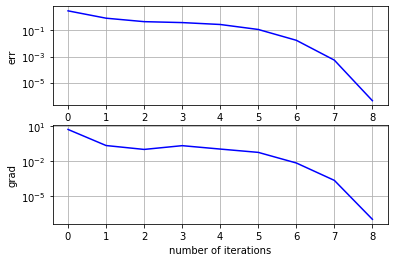

In [52]:
%matplotlib inline
# Plots
plt.subplot(2, 1, 1)
plt.ylabel("err")
plt.semilogy(log_err, linestyle='-', color='blue')
plt.grid()
plt.subplot(2, 1, 2)
plt.ylabel("grad")
plt.xlabel("number of iterations")
plt.semilogy(log_grad, linestyle='-', color='blue')
plt.grid()

Now, compare different outputs of the numerical inverse kinematics function using the line search algorithm but limiting the maximum number of iteration to 3, 4 and 5, how much is the difference between the final position and the target?

In [58]:
max_iterations = 5  # Maximum number of iterations

## desired task space position
p = np.array([-0.5, -0.2, 0.5, math.pi/3])

# initial guess (elbow up)
# q_i  = np.array([ 0.5, -1.5, 1.0, -math.pi])
# initial guess (elbow down)
# q_i  = np.array([ -0.5, 1.0, -0.8, -math.pi])
# initial guess (bad initialization)
q_i  = np.array([ -5.0, 5.0, -0.8, -math.pi])

# publish to ROS
ros_pub.add_marker(p[:3])
ros_pub.publish(robot, q_i)
tm.sleep(1)
q_f, log_err, log_grad  = numericalInverseKinematics(robot, p, q_i, epsilon, max_iterations, alpha, beta, line_search=True, wrap=True , publish=True)

the iterative algorithm has not reached convergence to the desired precision.
Error is: 0.11892728070699395


You can notice that the algorithm is converging very fast (the rate of convergence of Gauss-Newton method approaches the quadratic) and the robot is very close to the target already after 4 iterations.

Now, try to ask to reach a position of the end-effector *outside* of the workspace, for example, $p = {\begin{bmatrix}  -1.0 & -0.2 & 0.5 & \frac{\pi}{3}\end{bmatrix}}^T$. Start without the line search, is the error going to zero? verify that the algorithm never converges (the maximum number of iterations is reached). If you enable the line search the robot tries to do \"the best that he can\" to reach the target, reducing the error, but still the maximum number of iteration is reached. Increasing the regularization term $\lambda$ (e.g. to 0.01) you can see that the gradient goes under the tolerance $\epsilon$ before reaching the maximum value of iterations (and the error will be minimum).

A limitation of this approach is that joint limits can be considered only at the end. An improvement would be to set up a *constrained* optimization problem where we enforce the end-stop limits during the optimization.

In [84]:
%%time
max_iterations = 20  # Maximum number of iterations

# outside of workspace, gets the solution with minumum error
p = np.array([-1.0, -0.2, 0.5, math.pi/3])

# initial guess (elbow up)
# q_i  = np.array([ 0.5, -1.5, 1.0, -math.pi])
# initial guess (elbow down)
q_i = np.array([-0.5, 1.0, -0.8, -math.pi])
# initial guess (bad initialization)
# q_i  = np.array([ -5.0, 5.0, -0.8, -math.pi])

# publish initial position to ROS
ros_pub.add_marker(p[:3])
ros_pub.publish(robot, q_i)

CPU times: user 179 µs, sys: 265 µs, total: 444 µs
Wall time: 405 µs


In [85]:
q_f, log_err, log_grad  = numericalInverseKinematics(robot, p, q_i, epsilon, max_iterations, alpha, beta, line_search=True, wrap=True, publish=True)

the iterative algorithm has not reached convergence to the desired precision.
Error is: 0.3444183946961266


### 2.5 Fifth order joint polynomial trajectory

Now that we have a function that computes the inverse kinematics, we can use our initial joint position $\mathbf{q}_0$(defined in the file ) and the final joint position vector $\mathbf{q}_f$ (computed with our numerical inverse kinematics function) to compute a trajectory and move from one point to the other. An easy way to do so is by using a fifth order *polynomials* parameterized by time to represent the position and its derivatives (i.e., velocity and acceleration) of a given joint with respect to time, i.e.: 
$$
\begin{aligned}
    q_i(t) &= a_0  + a_1 t +  a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5\\
    \dot{q}_i(t) &= a_1 + 2 a_2 t + 3a_3 t^2 + 4 a_4 t^3 + 5 a_5 t^4\\
    \ddot{q}_i(t) &= 2 a_2 + 6 a_3 t + 12 a_4 t^2 + 20 a_5 t^3\end{aligned}
$$
 we can then define a set of *initial* and *final* conditions for the joint variables $q_i$, $\dot{q}_i(t)$ and $\ddot{q}_i(t)$ to define the behavior of the trajectory. Using this *boundary conditions* we can obtain the values of the coefficients $a_i$ by solving a $6\times 6$ linear system of equations (we have 6 equations and six unknowns). For the initial conditions we use the $\mathbf{q}_0$ and assume that the arm starts from a no-motion condition (i.e., $\dot{\mathbf{q}}_0 = \mathbf{0}$ and $\ddot{\mathbf{q}}_0 = \mathbf{0}$). For the final conditions we can use the joint values obtained by the inverse kinematics $\mathbf{q}_f$ and again assume that the robot will come to a full stop at the end of the motion (i.e., $\dot{\mathbf{q}}_f = \mathbf{0}$ and $\ddot{\mathbf{q}}_f = \mathbf{0}$). We initialize time $t_0 = 0$ and the final time $t_f$ we are free to choose (the shorter the time, the faster the robot will move). Let's select $t_f = 3s$. With these considerations, replacing $t = 0$ and $t = t_f$ the equations for initial and final conditions become (per joint): 
$$
    \begin{aligned}
    q_0 &= a_0  \\
    0 &= a_1 \\
    0 &= 2 a_2 \\
    q_f &= a_0  + a_1 t_f +  a_2 t_f^2 + a_3 t_f^3 + a_4 t_f^4 + a_5 t_f^5\\
    0 &= a_1 + 2 a_2 t_f + 3a_3 t_f^2 + 4 a_4 t_f^3 + 5 a_5 t_f^4\\
    0 &= 2 a_2 + 6 a_3 t_f + 12 a_4 t_f^2 + 20 a_5 t_f^3\end{aligned}
$$
 which can be rewritten in matrix form as: 
$$
    \begin{bmatrix}
        q_0 \\
        0 \\
        0 \\
        q_f \\
        0 \\
        0
    \end{bmatrix} =
    \begin{bmatrix}
        1 & 0   & 0     &       0 &        0 &     0 \\
        0 &   1 &     0 &       0 &        0 &     0 \\
        0 &   0 &     2 &       0 &        0 &     0 \\
        1 & t_f & t_f^2 &   t_f^3 &    t_f^4 & t_f^5 \\
        0 &   1 & 2 t_f & 3 t_f^2 &  4 t_f^3 & 5 t_f^4 \\
        0 &   0 &     2 &   6 t_f & 12 t_f^2 & 20 t_f^3
    \end{bmatrix}
    \begin{bmatrix}
        a_0 \\
        a_1 \\ 
        a_2 \\
        a_3 \\
        a_4 \\
        a_5
    \end{bmatrix}
$$
 Then we can pre-multiply both sides of the equation by the inverse of the square (6X6) matrix and on the right-hand side of the equation obtain the values for the coefficients of the polynomials. With these coefficients we can generate the whole trajectory $q(t)$ starting for a time $t=0$ (where $q = q_0$) up to $t=t_f$ (where $q = q_f$).





#### exercise 2.5: polynomial trajectory

Implement this trajectory by modifying the function . 

In [62]:
def fifthOrderPolynomialTrajectory(tf, initial_joint_position, final_joint_position, start_vel=0, end_vel=0, start_acc=0, end_acc = 0):

    # Matrix used to solve the linear system of equations for the polynomial trajectory
    polyMatrix = np.array([[1,  0,              0,               0,                  0,                0],
                           [0,  1,              0,               0,                  0,                0],
                           [0,  0,              2,               0,                  0,                0],
                           [1, tf,np.power(tf, 2), np.power(tf, 3),    np.power(tf, 4),  np.power(tf, 5)],
                           [0,  1,           2*tf,3*np.power(tf,2),   4*np.power(tf,3), 5*np.power(tf,4)],
                           [0,  0,              2,             6*tf, 12*np.power(tf,2),20*np.power(tf,3)]])
    
    polyVector = np.array([initial_joint_position, start_vel, start_acc, final_joint_position, end_vel, end_acc])
    matrix_inv = np.linalg.inv(polyMatrix)
    polyCoeff = matrix_inv.dot(polyVector)
  
    return polyCoeff

In [63]:
def simulation_5thPolynomialTrajectory(robot, q, q_f, dt = 0.001, SLOW_FACTOR=10):
    it = 0
    # Init variables
    zero = np.array([0.0, 0.0, 0.0, 0.0])
    time = 0.0
    # Init loggers
    q_log = np.empty((4))*np.nan
    qd_log = np.empty((4))*np.nan
    qdd_log = np.empty((4))*np.nan
    time_log = 0

    qd = np.zeros(4)
    qdd = np.zeros(4)

    while True:
        # Polynomial trajectory
        for i in range(4):
            a = fifthOrderPolynomialTrajectory(tf=3.0, initial_joint_position=q[i],final_joint_position=q_f[i], 
                                               start_vel=qd[i], end_vel = 0, start_acc =qdd[i], end_acc = 0)
            # a = fifthOrderPolynomialTrajectory(3.0, q[i], q_f[i], qd)
            q[i] = a[0] + a[1]*time + a[2]*time**2 + a[3]*time**3 + a[4]*time**4 + a[5]*time**5
            qd[i] = a[1] + 2 * a[2] * time + 3 * a[3] * time ** 2 + 4 * a[4] * time ** 3 + 5 * a[5] * time ** 4
            qdd[i] = 2 * a[2] + 6 * a[3] * time + 12 * a[4] * time ** 2 + 20 * a[5] * time ** 3
    
        # update time
        time = time + dt
    
        # Log Data into a vector
        time_log = np.append(time_log, time)
        q_log = np.vstack((q_log, q))
        qd_log = np.vstack((qd_log, qd))
        qdd_log = np.vstack((qdd_log, qdd))
    
        # publish joint variables 
        ros_pub.publish(robot, q, qd)
        # ros.sleep(dt*SLOW_FACTOR)
        tm.sleep(dt*SLOW_FACTOR)
    
        if  it > 1000:
            break
            
        if np.all(abs(q - q_f)<1e-6):
        # if np.count_nonzero(0):
            print(it)
            return time_log, q_log
            break
            
        # stops the while loop if  you prematurely hit CTRL+C
        if ros_pub.isShuttingDown():
            print("Shutting Down")
            break
        # print(it)
        it += 1

In [111]:
# hyper-parameters
alpha = 1  # Step size
epsilon = 1e-06 # Tolerance for stropping criterion
lambda_ = 1e-08  # Regularization or damping factor (1e-08->0.01)
max_iterations = 200  # Maximum number of iterations
beta = 0.5 # Step size reduction

## desired task space position
p = np.array([-0.5, -0.2, 0.5, math.pi/3])

# initial guess (elbow down)
q_i  = np.array([ -0.5, 1.0, -0.8, -math.pi])

# publish to ROS
ros_pub.add_marker(p[:3])
ros_pub.publish(robot, q_i)

# solution of the numerical ik
q_f, log_err, log_grad  = numericalInverseKinematics(robot, p, q_i, epsilon, max_iterations, alpha, beta, line_search=True, wrap=True, publish=False)

IK Convergence achieved!, norm(grad) : 8.896104805390229e-07
Inverse kinematics solved in 7 iterations


In [113]:
q = q_i.copy()
ros_pub.publish(robot, q)
ros_pub.add_marker(p)
tm.sleep(.5)
time_log, q_log = simulation_5thPolynomialTrajectory(robot, q, q_f ,dt=0.001, SLOW_FACTOR=50)

158


If you remove the *wrapping* feature you will get something even worse. This is because of the initialization that has a strong influence. Try to initialize the ik with $q_0$ instead than with $q_i$ and you will see that the trajectory improves significantly. However, if you set a target that is more far away (e.g. $p^d_e ={\begin{bmatrix}0.5 & -0.2 & 0.5\end{bmatrix}}^T$) you will still see loops. Using this approach to generate the trajectory is simple, but has no guarantee on what is happening (e.g. where the end-effector will be) in between the initial and the final configurations. Namely, you only now for sure where the end-effector is at the beginning and the end of the motion, which in real-life scenarios can lead to potential collisions or unwanted paths.

Plot the trajectories and see if you notice any problem. 
Hint: you can set a of 50 to better see the motion. You will see that the robot is doing very strange loops. 

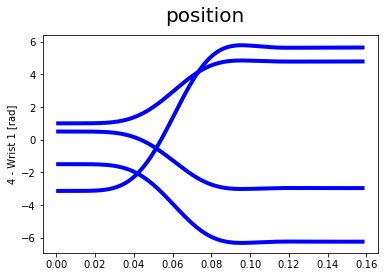

In [68]:
%matplotlib inline
fig = plotJoint('position', time_log, q_log.T)

**Cartesian trajectory:**   
The solution is to design a trajectory directly in Cartesian space via parametric curves. For instance you can design a trajectory of a line in 3D Cartesian space parameterized by time and, for each position given by the curve along the trajectory, you will need to compute the inverse kinematics to provide the joint values 

hint: you need to do it also at the velocity and at the acceleration level. 

As initial guess at each time instant you can set the configuration at the previous sample. 


Compare the results of the trajectory with respect to the one designed in 2.5.

In [114]:
def simulation_line_trajectory(robot, q, q_f, timesteps, dt = 0.001, SLOW_FACTOR=10):
    it = 0
    # Init variables
    zero = np.array([0.0, 0.0, 0.0, 0.0])
    time = 0.0
    # Init loggers
    q_log = np.empty((4))*np.nan
    qd_log = np.empty((4))*np.nan
    qdd_log = np.empty((4))*np.nan
    time_log = 0

    start_pos = getPose(q)
    end_pos = getPose(q_f)
    for i in range(timesteps + 1):
        current_pose = start_pos + (end_pos - start_pos) * (i / timesteps)
        q_f, log_err, log_grad  = numericalInverseKinematics(robot, current_pose, q, max_iterations=2000,line_search=True, wrap=True, publish=False)
        ros_pub.publish(robot, q_f)
        tm.sleep(dt*SLOW_FACTOR)
        q = q_f

    return time_log, q_log

In [122]:
## desired task space position
p = np.array([-0.5, -0.2, 0.5, math.pi/3])

# initial guess (elbow down)
q_i  = np.array([ -0.5, 1.0, -0.8, -math.pi])

# publish to ROS
ros_pub.add_marker(p[:3])
ros_pub.publish(robot, q_i)

# solution of the numerical ik
q_f, log_err, log_grad  = numericalInverseKinematics(robot, p, q_i, epsilon, max_iterations, alpha, beta, line_search=True, wrap=True, publish=False)

IK Convergence achieved!, norm(grad) : 8.896104805390229e-07
Inverse kinematics solved in 7 iterations


In [123]:
%%time
%%capture
q = q_i.copy()
time_log, q_log = simulation_line_trajectory(robot, q, q_f, timesteps=500,  dt=0.001, SLOW_FACTOR=20)
# view the result on RViz

CPU times: user 7.13 s, sys: 25.3 s, total: 32.4 s
Wall time: 10.6 s


## Conclusion

In conclusion, Assignment 1 has provided an immersive and comprehensive tutorial covering essential aspects of robotic manipulators. Throughout this assignment, we have explored the following key topics:

1. **Visualizing Robot Models with URDF:** We have learned how to describe a 4-DoF anthropomorphic robot using the Unified Robot Description Format (URDF). This enabled us to visualize the robot model using ROS and the RVIZ visualizer tool.

2. **Kinematics Computation:** We have developed Python code to calculate both direct and inverse kinematics for our robot manipulator. By understanding the relationship between joint angles and end-effector positions, we gained the ability to plan robot trajectories using simple polynomials.

By the end of this assignment, you have acquired a solid understanding of URDF, kinematics, and dynamics of robotic manipulators. Armed with this knowledge, you are now well-equipped to delve deeper into the exciting world of robotics, exploring advanced control strategies, trajectory planning, and more complex robot models.